In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import scipy.sparse as sparse
from scipy.sparse.linalg import spsolve
from sklearn.decomposition import PCA
from tqdm import tqdm
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, BatchNormalization
from tensorflow.keras.layers import Conv2D, Flatten, Conv1D
from tensorflow.keras.layers import Reshape, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
from scipy.signal import lfilter
import solverFunctions as sf
import analysisFunctions as af

array([ 6.31593543e-17, -6.31593543e-17,  1.97372982e-17, ...,
        1.89478063e-16, -6.31593543e-17,  0.00000000e+00])

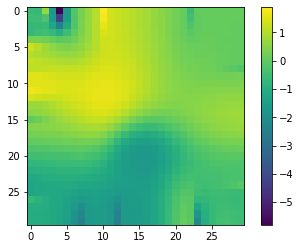

In [13]:
x_train[:,:,:,2] = x_train[:,:,:,2] - np.expand_dims(x_train[:,:,:,2].mean((1,2)),axis=(1,2))
p = x_train[:,:,:,2]
plt.imshow(p[0,:,:])
plt.colorbar()
p.mean((1,2))

In [48]:
def GetEncoder1(n_latent,input_shape):
    input_imag = Input(shape=input_shape, name='encoder_input')
    x = Flatten()(input_imag)
    latent = Dense(n_latent)(x)
    encoder = Model(input_imag,latent,name="encoder")
    return encoder

def GetDecoder(n_latent,input_shape):
    input_latent = Input(shape=(n_latent,))
    x = Dense(input_shape[0]*input_shape[1]*input_shape[2],use_bias=False)(input_latent)
    x = Reshape((input_shape[0],input_shape[1],input_shape[2]))(x)
    decoder = Model(input_latent,x,name="decoder")
    return decoder

def GetAE(input_shape,n_latent):
    input_imag = Input(shape=input_shape, name='encoder_input')
    encoder = GetEncoder1(n_latent,input_shape)
    decoder = GetDecoder(n_latent,input_shape)
    model = Model(input_imag, decoder(encoder(input_imag)))
    
    return model, encoder, decoder

In [269]:
xRe = np.max(np.sqrt(x_train[:,:,:,0]**2+x_train[:,:,:,1]**2),axis=(1,2))
xRe.shape

(15850,)

In [268]:
def getXtrain(order_bc):
    order_bc = 5
    u = np.load(r"DataDC/datasetDC_u_30_1_"+str(order_bc)+".npy")
    v = np.load(r"DataDC/datasetDC_v_30_1_"+str(order_bc)+".npy")
    p = np.load(r"DataDC/datasetDC_p_30_1_"+str(order_bc)+".npy")
    u_train = (u[:,1:,1:-1]+u[:,:-1,1:-1])/2
    u_train = np.expand_dims(u_train,axis=-1)
    v_train = (v[:,1:-1,1:]+v[:,1:-1,:-1])/2
    v_train = np.expand_dims(v_train,axis=-1)
    p_train = p
    p_train = np.expand_dims(p_train,axis=-1)
    x_train = np.concatenate([u_train,v_train,p_train],axis=3)
    return x_train

x_train = np.concatenate([getXtrain(2),getXtrain(5)],axis=0)
x_train2 = getXtrain(2)
x_train5 = getXtrain(5)
xRe = np.max((x_train[:,:,:,0]**2+x_train[:,:,:,1]**2))
x_train.shape

(15850, 30, 30, 3)

In [156]:
np.isnan(x_train).any()

False

In [161]:
n_image = 30
n_latent = 9
model,encoder,decoder = GetAE((n_image,n_image,3),n_latent)
optimizer = tf.keras.optimizers.Adam(0.0002)
model.compile(loss='mse', optimizer=optimizer,metrics=['mse'])
history_l = model.fit(x_train,x_train,epochs=200,batch_size=32,validation_split=0.2,shuffle=True)

Epoch 1/200
397/397 [==============================] - 1s 3ms/step - loss: 1.9259 - mse: 1.9259 - val_loss: 0.6286 - val_mse: 0.6286
Epoch 2/200
397/397 [==============================] - 1s 2ms/step - loss: 0.6129 - mse: 0.6129 - val_loss: 0.5936 - val_mse: 0.5936
Epoch 3/200
397/397 [==============================] - 1s 3ms/step - loss: 0.5670 - mse: 0.5670 - val_loss: 0.5399 - val_mse: 0.5399
Epoch 4/200
397/397 [==============================] - 1s 3ms/step - loss: 0.5134 - mse: 0.5134 - val_loss: 0.4857 - val_mse: 0.4857
Epoch 5/200
397/397 [==============================] - 1s 3ms/step - loss: 0.4705 - mse: 0.4705 - val_loss: 0.4449 - val_mse: 0.4449
Epoch 6/200
397/397 [==============================] - 1s 3ms/step - loss: 0.4293 - mse: 0.4293 - val_loss: 0.4083 - val_mse: 0.4083
Epoch 7/200
397/397 [==============================] - 1s 3ms/step - loss: 0.3969 - mse: 0.3969 - val_loss: 0.3796 - val_mse: 0.3796
Epoch 8/200
397/397 [==============================] - 1s 3ms/step - 

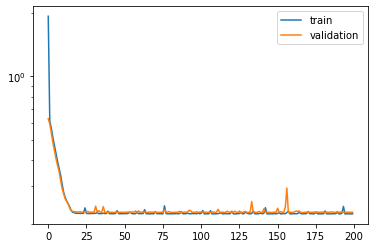

In [162]:
plt.plot(history_l.history['mse'])
plt.plot(history_l.history['val_mse'])
plt.gca().set_yscale("log")
plt.legend(["train","validation"])

100%|██████████| 9/9 [00:02<00:00,  4.09it/s]


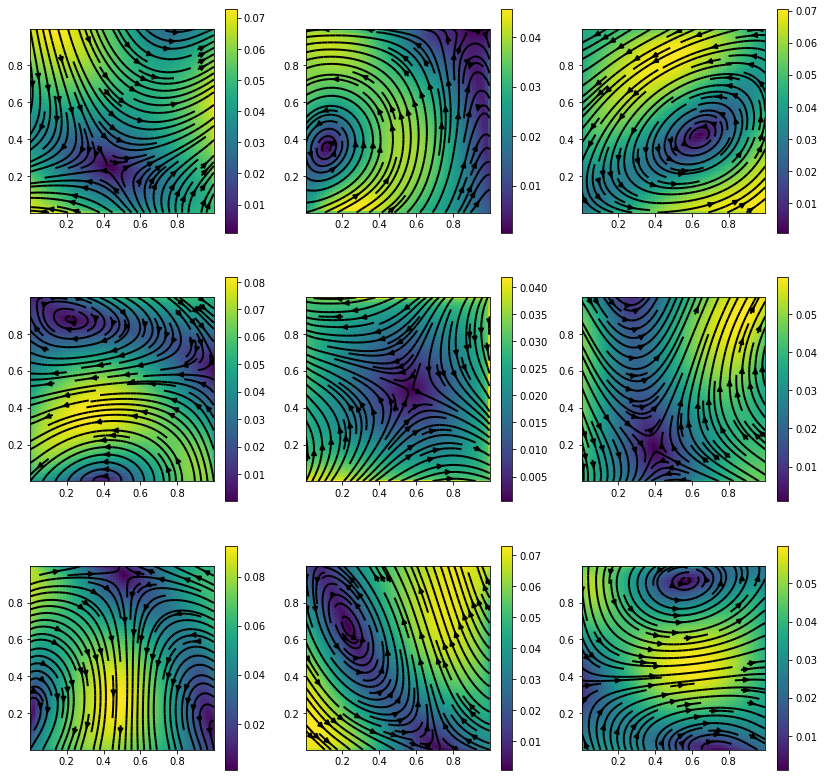

In [163]:
eig = decoder.trainable_variables[0].numpy().reshape(n_latent,30,30,3)
af.PlotX(3,3,eig,prob)

100%|██████████| 4/4 [00:01<00:00,  2.66it/s]


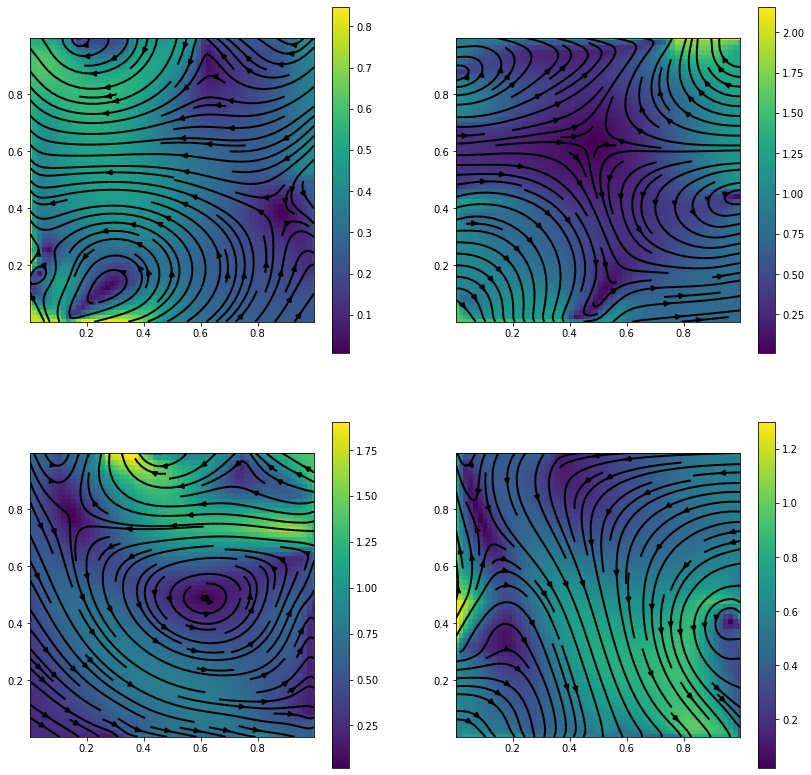

100%|██████████| 4/4 [00:01<00:00,  3.48it/s]


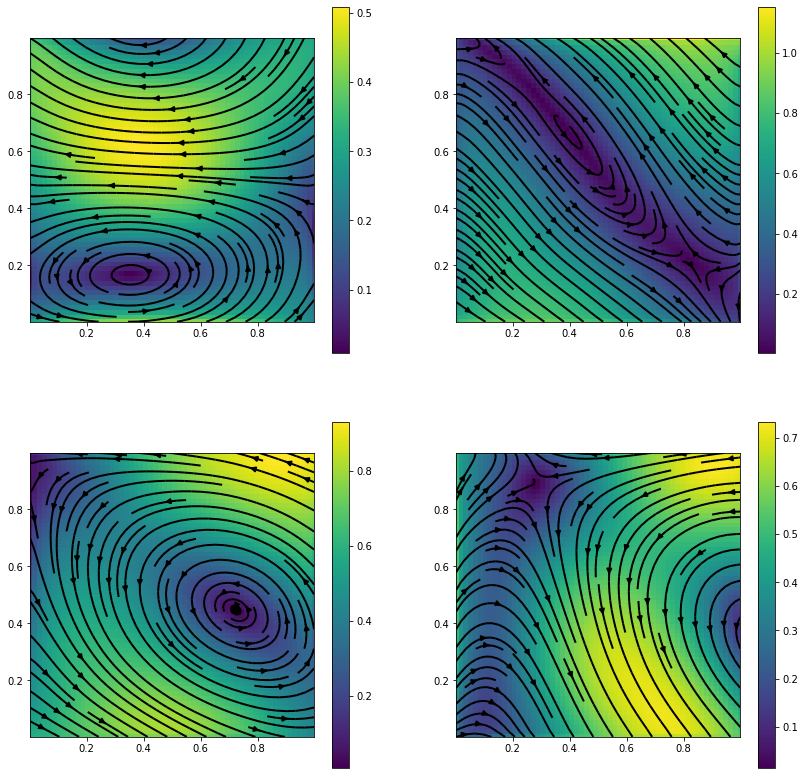

In [180]:
indexes = np.arange(x_train.shape[0])
np.random.shuffle(indexes)
x_train = x_train[indexes]
x_sample = x_train[7007:]
x_recon = model(x_sample).numpy()
af.PlotX(2,2,x_sample,prob)
af.PlotX(2,2,x_recon,prob)

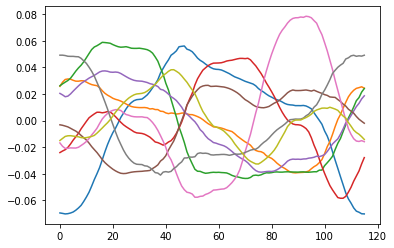

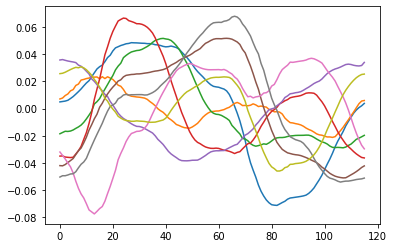

In [166]:
def GetBoundary(x):
    if (len(x.shape)==4):
        u_n = x[:,:,:,0]
        v_n = x[:,:,:,1]
        u_bc = np.concatenate([u_n[:,:-1,0],u_n[:,-1,:-1],u_n[:,1:,-1][:,::-1],u_n[:,0,1:][:,::-1]],axis=-1)
        v_bc = np.concatenate([v_n[:,:-1,0],v_n[:,-1,:-1],v_n[:,1:,-1][:,::-1],v_n[:,0,1:][:,::-1]],axis=-1)
    else:
        u_n = x[:,:,0]
        v_n = x[:,:,1]
        u_bc = np.concatenate([u_n[:-1,0],u_n[-1,:-1],u_n[1:,-1][::-1],u_n[0,1:][::-1]])
        v_bc = np.concatenate([v_n[:-1,0],v_n[-1,:-1],v_n[1:,-1][::-1],v_n[0,1:][::-1]])
    return u_bc,v_bc

u_bc,v_bc = GetBoundary(eig)
plt.plot(np.transpose(u_bc))
plt.show()
plt.plot(np.transpose(v_bc))
plt.show()

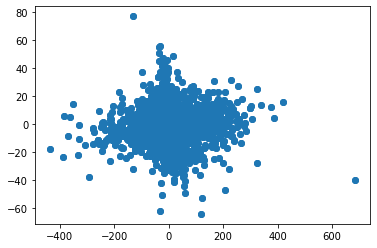

In [177]:
mean = encoder(x_train[:]).numpy()
# plt.scatter(mean[:,0],mean[:,1])
pca = PCA(n_components=2)
pca_fit = pca.fit(mean)
points = pca_fit.transform(mean)
plt.scatter(points[:,0],points[:,1])


In [178]:
d = abs(points[:,0])+abs(points[:,1])
i = np.argmax(d)
i

7008

In [249]:
def GetEncoderNL(n_latent,image):
    input_e = Input(image)
    x = Flatten()(input_e)
    x = Dense(100,activation='sigmoid')(x)
    x = BatchNormalization()(x)
    x = Dense(100,activation='sigmoid')(x)
    x = BatchNormalization()(x)
    mean = Dense(n_latent)(x)
    log_var = Dense(n_latent)(x)
    encoder = Model(input_e,[mean,log_var])
    return encoder

def GetDecoderNL(n_latent,image):
    input_d = Input(n_latent)
    x = Dense(100,activation='sigmoid')(input_d)
    x = BatchNormalization()(x)
    x = Dense(100,activation='sigmoid')(x)
    x = BatchNormalization()(x)
    x = Dense(image[0]*image[1]*image[2])(x)
    out_d = Reshape((image[0],image[1],image[2]))(x)
    decoder = Model(input_d,out_d)
    return decoder

def GetEncoderNL2(n_latent,image):
    input_e = Input(image)
    x = Conv2D(8,10,activation="sigmoid",strides=(2,2))(input_e)
    x = BatchNormalization()(x)
    x = Conv2D(16,10,activation="sigmoid",strides=(2,2))(x)
    x = BatchNormalization()(x)
    x = Flatten()(x)
    mean = Dense(n_latent)(x)
    log_var = Dense(n_latent)(x)
    encoder = Model(input_e,[mean,log_var])
    return encoder

def GetDecoderNL2(n_latent,image):
    input_d = Input(n_latent)
    x = Dense(20,activation='sigmoid')(input_d)
    x = BatchNormalization()(x)
    x = Dense(20,activation='sigmoid')(x)
    x = BatchNormalization()(x)
    x = Dense(image[0]*image[1])(x)
    out_d = Reshape((image[0],image[1],1))(x)
    decoder = Model(input_d,out_d)
    return decoder

def GetModelAENL(n_latent,image):
    encoder = GetEncoderNL(n_latent,image)
    decoder = GetDecoderNL(n_latent,image)
    model = Model(input_e,decoder(encoder(input_e)))
    return model,encoder,decoder

class ModelVAE_NL(Model):
    
    def __init__(self,n_latent,input):
        super(ModelVAE_NL,self).__init__()
        self.n_latent = n_latent
        self.encoder = GetEncoderNL(n_latent,input)
        self.decoder = GetDecoderNL(n_latent,input)
        
    def sample(self,z_mean,z_logsigma):
        batch, latent_dim = z_mean.shape
        epsilon = tf.random.normal(shape=(batch, latent_dim))
        z = z_mean + tf.math.exp(0.5 * z_logsigma) * epsilon
        return z
    
    def encode(self,x):
        mean, log_var = self.encoder(x)
        z = self.sample(mean,log_var)
        return z, mean, log_var
        
    def decode(self,z):
        x_r = self.decoder(z)
        return x_r
        
    def call(self,x):
        z, mean, log_var = self.encode(x)
        x_r = self.decode(z)
        return x_r, mean, log_var
    
    def reconstruct(self,x):
        mean,_ = self.encoder(x)
        x_r = self.decoder(mean)
        return x_r
    
class ModelVAE_NL2(Model):
    
    def __init__(self,n_latent,n_input):
        super(ModelVAE_NL2,self).__init__()
        self.n_latent = n_latent
        self.encoder = GetEncoderNL2(n_latent,(n_input,n_input,1))
        self.decoder = GetDecoderNL2(n_latent,(n_input,n_input,1))
        
    def sample(self,z_mean,z_logsigma):
        batch, latent_dim = z_mean.shape
        epsilon = tf.random.normal(shape=(batch, latent_dim))
        z = z_mean + tf.math.exp(0.5 * z_logsigma) * epsilon
        return z
    
    def encode(self,x):
        mean, log_var = self.encoder(x)
        z = self.sample(mean,log_var)
        return z, mean, log_var
        
    def decode(self,z):
        x_r = self.decoder(z)
        return x_r
        
    def call(self,x):
        z, mean, log_var = self.encode(x)
        x_r = self.decode(z)
        return x_r, mean, log_var
    
    def reconstruct(self,x):
        mean,_ = self.encoder(x)
        x_r = self.decoder(mean)
        return x_r
    
# def vae_loss_function(x, x_recon, mu, logsigma,kl_weight,A,fd_weight):
#     latent_loss = 0.5 * tf.reduce_sum(tf.exp(logsigma) + tf.square(mu) - 1.0 - logsigma, axis=1)
#     reconstruction_loss = tf.reduce_mean(tf.square(x-x_recon), axis=(1,2,3))
#     fd_loss = tf.reduce_mean(tf.square(tf.matmul(A,tf.reshape(x_recon,\
#         shape=(x_recon.shape[0],x_recon.shape[1]*x_recon.shape[2],1)))),axis=(1,2))
#     vae_loss = kl_weight * latent_loss + reconstruction_loss + fd_weight * fd_loss
#     return vae_loss,reconstruction_loss,latent_loss,fd_loss

def vae_loss_function(x, x_recon, mu, logsigma,kl_weight):
    latent_loss = 0.5 * tf.reduce_sum(tf.exp(logsigma) + tf.square(mu) - 1.0 - logsigma, axis=1)
    reconstruction_loss = tf.reduce_mean(tf.square(x-x_recon), axis=(1,2,3))
    vae_loss = kl_weight * latent_loss + reconstruction_loss
    return vae_loss,reconstruction_loss,latent_loss

@tf.function
def train_step_VAE(modelVAE,optimizer,images,kl_weight):
    with tf.GradientTape() as tape:
        
        (images_r, mu, log_vat) = modelVAE(images)
        images = tf.cast(images,tf.float32)
        loss,r_loss,l_loss = vae_loss_function(images,images_r, mu, log_vat,kl_weight)

    grads = tape.gradient(loss,modelVAE.trainable_variables)
    optimizer.apply_gradients(zip(grads,modelVAE.trainable_variables))
    return loss,r_loss,l_loss

class History():
    def __init__(self,n):
        self.loss = np.zeros(n)
        self.r_loss = np.zeros(n)
        self.l_loss = np.zeros(n)
        self.fd_loss = np.zeros(n)
        
    def add(self,history):
        self.loss = np.concatenate([self.loss,history.loss],axis=0)
        self.r_loss = np.concatenate([self.r_loss,history.r_loss],axis=0)
        self.l_loss = np.concatenate([self.l_loss,history.l_loss],axis=0)
        self.fd_loss = np.concatenate([self.fd_loss,history.fd_loss],axis=0)

def train_VAE(modelVAE,optimizer,x_train,n_epochs,n_batch,kl_weight=0.005):
    n_steps = n_epochs*len(range(0,x_train.shape[0],n_batch))
    history = History(n_steps)
    index = 0
    for epoch in range(n_epochs):
        i = np.arange(x_train.shape[0])
        np.random.shuffle(i)
        x_train = x_train[i,:,:,:]
#         x_train_shuffled = tf.cast(x_train_shuffled,tf.float32)

        for batch in range(0,x_train.shape[0],n_batch):
            loss,r_loss,l_loss = train_step_VAE(modelVAE,optimizer,x_train[batch:batch+n_batch],kl_weight)
            history.loss[index] = tf.reduce_mean(loss)
            history.r_loss[index] = tf.reduce_mean(r_loss)
            history.l_loss[index] = tf.reduce_mean(l_loss)
            # history.fd_loss[index] = tf.reduce_mean(fd_loss)
            
            print("\r{}/{} epochs - {:.3g}%; loss = {:.5g}".format(epoch+1,n_epochs, 100*batch/x_train.shape[0],history.loss[index]),end="\t") #
            index+=1
            
        print("\r{}/{} epochs - {:.3g}%; loss = {:.5g}".format(epoch+1,n_epochs, 100,history.loss[index-10:index-1].mean()),end="\t") #
            
    return history

In [250]:
n_batch = 128
n_epochs = 2000
kl_weight = 0.005 #kl_weight = 0.0005
n_latent = 10
input_shape = x_train[0].shape
lr = 0.001

# modelVAE = ModelVAE_NL(n_latent,input_shape)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

lhistory_part = train_VAE(modelVAE,optimizer,x_train,n_epochs,n_batch,kl_weight)
print()
if ('lhistory' in locals()):
    lhistory.add(lhistory_part)
    print("add")
else:
    lhistory = lhistory_part
    print("define")

2000/2000 epochs - 100%; loss = 0.72473																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																	

Text(0, 0.5, 'loss')

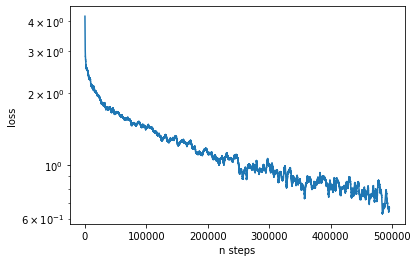

In [251]:
n_filt = 2000
a = np.ones(n_filt)
h = lfilter(a,a.sum(),lhistory.r_loss[:])
ax = plt.subplot()
ax.plot(h[n_filt:])
ax.set_yscale('log')
plt.xlabel("n steps")
plt.ylabel("loss")

array([2.224284  , 1.2155701 , 1.8999951 , 1.6572113 , 2.3675075 ,
       1.6438677 , 2.3400142 , 0.13902488, 0.16256043, 1.1095372 ],
      dtype=float32)

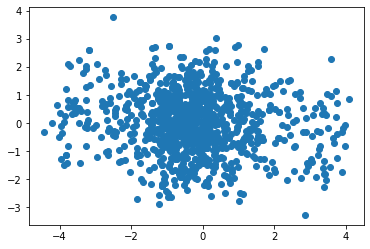

In [267]:
mean,logvar=modelVAE.encoder(x_train[:1000])
a = mean.numpy().var(0)
i = np.where(a>0.1)
plt.scatter(mean[:,0],mean[:,1])
a


100%|██████████| 16/16 [00:04<00:00,  3.78it/s]


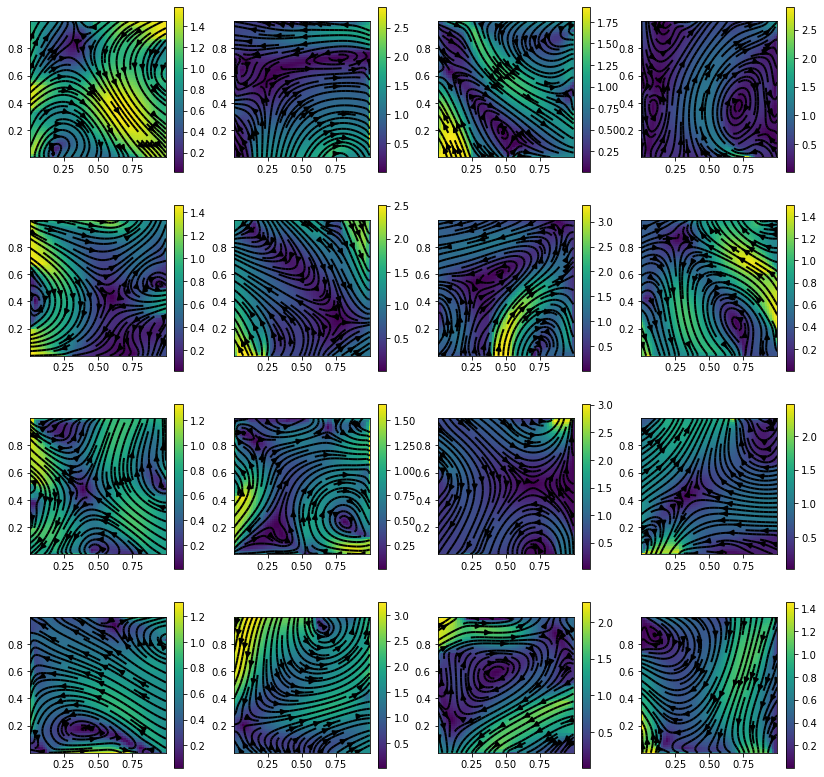

100%|██████████| 16/16 [00:04<00:00,  3.71it/s]


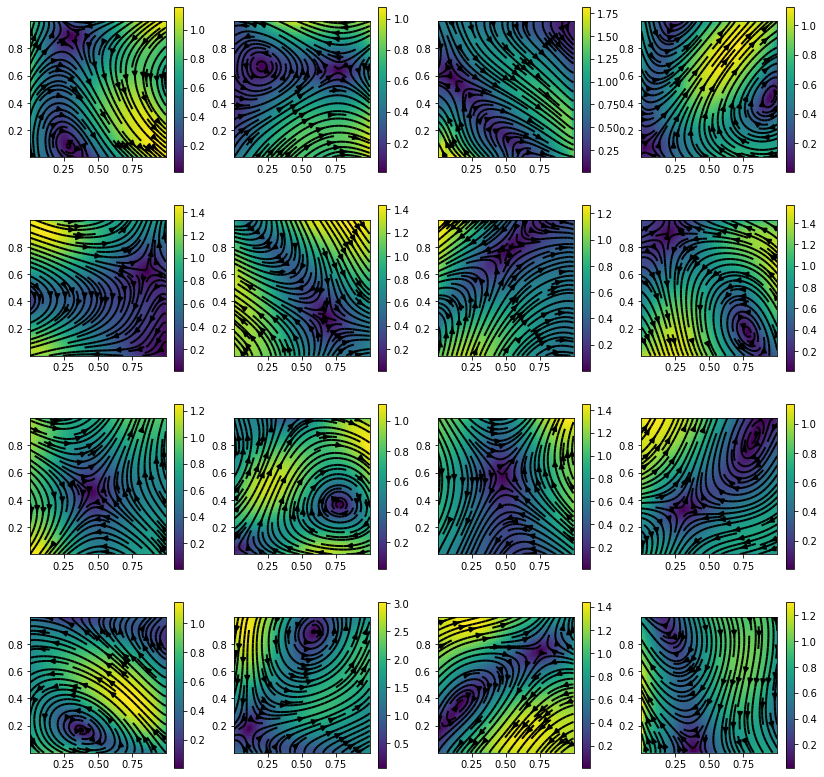

In [264]:
# np.exp(logvar.numpy().mean(0))
indexes = np.arange(x_train.shape[0])
np.random.shuffle(indexes)
x_train = x_train[indexes]
x_sample = x_train[:]
x_recon = modelVAE.reconstruct(x_sample).numpy()
af.PlotX(4,4,x_sample,prob)
af.PlotX(4,4,x_recon,prob)